# Using ML for paramter estimation

In [1]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
np.random.seed(1333)

"""Loading the Data"""

dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'
UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')
UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)
dataset = np.array(UX1.PX_LAST)
dataset = dataset[4:]              #we drop 4 data for simpler illustratoins

In [2]:
"""Specifying the Input & Output (Labels)"""

n=30     #Looking at n previous days to estimate paramteres
X=np.array([[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n)])
Y=np.array([dataset[i+n] for i in range(len(dataset) - n)])

In [3]:
"""Splitting Data into Train and Test set"""

m_training= 2000
m_test= 1000

X_training=X[:m_training]
Y_training=Y[:m_training]

X_test=X[m_training:]
Y_test=Y[m_training:]

In [4]:
"""Building the Hypothesis"""

def heston_pde_milstein(v_0, r, k, theta, rho, sigma):
    
    dt         = 1
    size       = (1, 1)
    volatility = np.zeros(size)
    v_t        = np.full (1,  v_0)
    
    for t in range(1):
        WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=1 )
        v_t = np.abs(v_t + k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT[:, 1] + .25 * sigma**2 * ( WT[:,1]**2 - dt ) )
        volatility[:, t] = v_t
        
    return volatility       

In [23]:
#Paramteres
theta   = 1
k       = 1
sigma   = 1
rho     = 1
r       = 0

vol    = np.empty((UX1.index.size - n, 1))

VIX=[]
n       = 20    #don't touch
for i in range(n,UX1.index.size):
    
    Vt          = UX1.PX_LAST.iloc[i-n:i].values**2
    V0          = Vt[-1]
    v           = heston_pde_milstein(V0, r, k, theta, rho, sigma)
    VIX.append(np.sqrt(v[0][0]))
    
VIX=np.array(VIX)

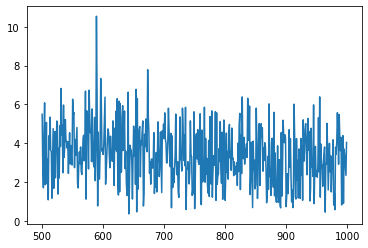

In [30]:
plt.plot([t for t in range(len(VIX))][500:1000], VIX[500:1000])

In [ ]:
"""Building the Loss Function"""

In [ ]:
"""Minimizing the Loss Function"""